In [1]:
using Pkg
Pkg.activate("./")
Pkg.instantiate()

  Activating project at `~/Documents/UCL/3x2_analytical`


In [8]:
using LinearAlgebra
using ForwardDiff
using Plots
using LimberJack
using CSV
using YAML
using NPZ
using DataFrames
using PythonCall
sacc = pyimport("sacc");

# Judith's Chain

In [9]:
using DelimitedFiles
chain = readdlm("/home/jaimerz/Documents/UCL/3x2_analytical/data/CosmoDC2/cosmodc2_3x2pt_fourier_lcdm.txt");

In [10]:
chain_vals = chain[200:end, :]
param_names = chain[1, :];

post = chain_vals[:, 32]
index_of_min = argmax(post)
row_with_min = chain_vals[index_of_min, :]
Wm = row_with_min[1]+row_with_min[2]
Wb = row_with_min[2]
h0 = row_with_min[5]
ns = row_with_min[3]
s8 = row_with_min[29]
best_params = [Wm, Wb, h0, s8, ns]
print(best_params)

nuisances = Dict(
    "lens_0_b" => row_with_min[13],
    "lens_1_b" => row_with_min[14],
    "lens_2_b" => row_with_min[15],
    "lens_3_b" => row_with_min[16],
    "lens_4_b" => row_with_min[17],
    "source_0_m" => row_with_min[8],
    "source_1_m" => row_with_min[9],
    "source_2_m" => row_with_min[10],
    "source_3_m" => row_with_min[11],
    "source_4_m" => row_with_min[12])

[0.2734714358876248, 0.042170616570847225, 0.7189925511925751, 0.7790071910238021, 0.9965136823002241]

Dict{String, Float64} with 10 entries:
  "lens_0_b"   => 0.879118
  "source_3_m" => -0.00278755
  "lens_2_b"   => 1.22145
  "source_2_m" => 0.00434908
  "lens_4_b"   => 1.58909
  "source_0_m" => -0.00733846
  "source_4_m" => 0.000101118
  "lens_1_b"   => 1.05894
  "lens_3_b"   => 1.35065
  "source_1_m" => -0.00434667

In [11]:
function make_Cmod(dz_mean, dz_cov, data_cov, model; mode="AD")
    m = size(dz_cov)[1]
    n_cls = size(data_cov)[1]
    T = zeros(n_cls, m)

    if mode == "AD"
        println("Using automatic differentiation to compute T")
        T = ForwardDiff.jacobian(model, dz_mean)
    elseif mode == "FD"
        println("Using finite differences to compute T")
        d = 0.05
        for i in 1:m
            e = zeros(m)
            e[i] = d
            T[:, i] = (model(dz_mean.+e) .- model(dz_mean.-e)) ./ (2*d)
        end
    end
    TPT = T * dz_cov * T'
    Cmod = Symmetric(data_cov + TPT)
    return Cmod
end

make_Cmod (generic function with 1 method)

In [12]:
#dz_err_wlwl = [0.017, 0.017, 0.013, 0.015]
#dz_err_gcgc = [0.007, 0.007, 0.006, 0.01, 0.01]
#dz_err_3x2 = [dz_err_wlwl; dz_err_gcgc]

#dz_cov_wlwl = diagm(dz_err_wlwl.^2)
#dz_cov_gcgc = diagm(dz_err_gcgc.^2)
#dz_cov_3x2 = diagm(dz_err_3x2.^2);

## WLWL

In [13]:

method = "bpz"
sacc_path = "./data/CosmoDC2/summary_statistics_fourier_tjpcov.sacc"
yaml_path = "./data/CosmoDC2/wlwl.yml"
nz_path = string("./data/CosmoDC2/image_nzs_", method, "_priors/")
dz_path = string("./data/CosmoDC2/image_dz_", method, "_priors/dz_prior.npz")
fake_data_path = string("./data/CosmoDC2/CosmoDC2_wlwl_theory_photo_", method, "_best.csv")

fake_data = CSV.read(fake_data_path, DataFrame)
fake_data = fake_data.theory[1:end-1]

sacc_file = sacc.Sacc().load_fits(sacc_path)
yaml_file = YAML.load_file(yaml_path)

nz_source_0 = npzread(string(nz_path, "nz_source_0.npz"))
nz_source_1 = npzread(string(nz_path, "nz_source_1.npz"))
nz_source_2 = npzread(string(nz_path, "nz_source_2.npz"))
nz_source_3 = npzread(string(nz_path, "nz_source_3.npz"))
nz_source_4 = npzread(string(nz_path, "nz_source_4.npz"))
zs_k0, nz_k0 = nz_source_0["z"], nz_source_0["dndz"]
zs_k1, nz_k1 = nz_source_1["z"], nz_source_1["dndz"]
zs_k2, nz_k2 = nz_source_2["z"], nz_source_2["dndz"]
zs_k3, nz_k3 = nz_source_3["z"], nz_source_3["dndz"]
zs_k4, nz_k4 = nz_source_4["z"], nz_source_4["dndz"]
mu_k0 = sum(zs_k0 .* nz_k0) / sum(nz_k0)
mu_k1 = sum(zs_k1 .* nz_k1) / sum(nz_k1)
mu_k2 = sum(zs_k2 .* nz_k2) / sum(nz_k2)
mu_k3 = sum(zs_k3 .* nz_k3) / sum(nz_k3)
mu_k4 = sum(zs_k4 .* nz_k4) / sum(nz_k4)

dz_prior = npzread(dz_path)
dz_mean, dz_cov = dz_prior["mean"], dz_prior["cov"]
dz_mean_wlwl = dz_mean[1:10]
dz_cov_wlwl = dz_cov[1:10, 1:10]
dz_chol_wlwl = cholesky(dz_cov_wlwl).U'

meta_wlwl, files_wlwl = make_data(sacc_file, yaml_file;
                        nz_source_0=nz_source_0,
                        nz_source_1=nz_source_1,
                        nz_source_2=nz_source_2,
                        nz_source_3=nz_source_3,
                        nz_source_4=nz_source_4)

meta_wlwl.types = [    
    "galaxy_shear", 
    "galaxy_shear", 
    "galaxy_shear",
    "galaxy_shear",
    "galaxy_shear"]

source_0 source_0 15
source_1 source_0 15
source_1 source_1 15
source_2 source_0 15
source_2 source_1 15
source_2 source_2 15
source_3 source_0 15
source_3 source_1 15
source_3 source_2 15
source_3 source_3 15
source_4 source_0 15
source_4 source_1 15
source_4 source_2 15
source_4 source_3 15
source_4 source_4 15
using custom nz for nz_source_0
using custom nz for nz_source_1
using custom nz for nz_source_2
using custom nz for nz_source_3
using custom nz for nz_source_4


5-element Vector{String}:
 "galaxy_shear"
 "galaxy_shear"
 "galaxy_shear"
 "galaxy_shear"
 "galaxy_shear"

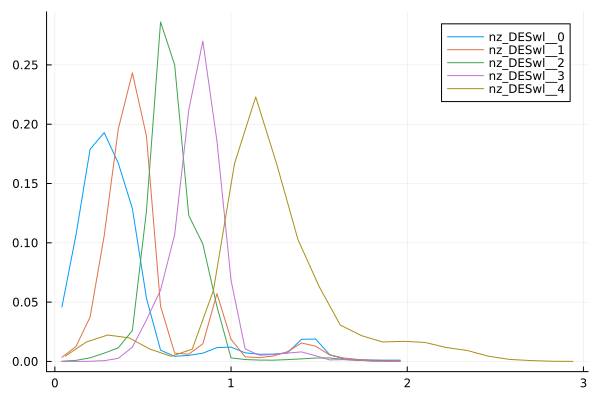

In [14]:
plot(files_wlwl["nz_source_0"][1], files_wlwl["nz_source_0"][2], label="nz_DESwl__0")
plot!(files_wlwl["nz_source_1"][1], files_wlwl["nz_source_1"][2], label="nz_DESwl__1")
plot!(files_wlwl["nz_source_2"][1], files_wlwl["nz_source_2"][2], label="nz_DESwl__2")
plot!(files_wlwl["nz_source_3"][1], files_wlwl["nz_source_3"][2], label="nz_DESwl__3")
plot!(files_wlwl["nz_source_4"][1], files_wlwl["nz_source_4"][2], label="nz_DESwl__4")

In [28]:
function model_wlwl(alphas; meta=meta_wlwl, files=files_wlwl)
    SnWs = dz_mean_wlwl .+ dz_chol_wlwl * alphas
    dzs = [SnWs[1], SnWs[3], SnWs[5], SnWs[7], SnWs[9]]
    wzs = [SnWs[2], SnWs[4], SnWs[6], SnWs[8], SnWs[10]]
    source_0_zs = @.((zs_k0-mu_k0)/wzs[1] + mu_k0 + dzs[1])
    source_1_zs = @.((zs_k1-mu_k1)/wzs[2] + mu_k1 + dzs[2])
    source_2_zs = @.((zs_k2-mu_k2)/wzs[3] + mu_k2 + dzs[3])
    source_3_zs = @.((zs_k3-mu_k3)/wzs[4] + mu_k3 + dzs[4])
    source_4_zs = @.((zs_k4-mu_k4)/wzs[5] + mu_k4 + dzs[5])

    nuisances = Dict(
        "source_0_b"    => 0.879118,
        "source_1_b"    => 1.05894,
        "source_2_b"    => 1.22145,
        "source_3_b"    => 1.35065,
        "source_4_b"    => 1.58909,
        "source_0_zs"   => source_0_zs,
        "source_1_zs"   => source_1_zs,
        "source_2_zs"   => source_2_zs,
        "source_3_zs"   => source_3_zs,
        "source_4_zs"   => source_4_zs,
        "source_0_m"  => -0.00733846,
        "source_1_m"  => -0.00434667,
        "source_2_m"  => 0.00434908,
        "source_3_m"  => -0.00278755,
        "source_4_m"  => 0.000101118)
        
    cosmo = Cosmology(
        Ωm=best_params[1],
        Ωb=best_params[2],
        h=best_params[3],
        σ8=best_params[4],
        ns=best_params[5],
        tk_mode=:EisHu,
        pk_mode=:Halofit)

    cosmo.settings.cosmo_type = eltype(valtype(alphas))
    return Theory(cosmo, meta, files; Nuisances=nuisances)
end;

In [29]:
Cmod_wlwl_FD = make_Cmod(dz_mean_wlwl, diagm(ones(10)), meta_wlwl.cov, model_wlwl; mode="FD")
Cmod_wlwl_AD = make_Cmod(dz_mean_wlwl, diagm(ones(10)), meta_wlwl.cov, model_wlwl; mode="AD")

Using finite differences to compute T
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
Using automatic differentiation to compute T
10


225×225 Symmetric{Float64, Matrix{Float64}}:
  1.01328e-16  -1.98828e-17   4.56955e-18  …  -9.78113e-22  -6.62035e-22
 -1.98828e-17   1.90563e-17  -2.30243e-18     -7.08338e-22  -4.79303e-22
  4.56955e-18  -2.30243e-18   4.76438e-18     -4.84654e-22  -3.27957e-22
  1.78457e-19   7.11979e-19  -2.6541e-19      -3.19204e-22  -2.15994e-22
  3.97377e-19   2.17878e-19   2.11559e-19     -2.03438e-22  -1.37657e-22
  2.23059e-19   1.5934e-19    1.06146e-19  …  -1.30269e-22  -8.81447e-23
  1.479e-19     1.03094e-19   7.16027e-20     -8.56635e-23  -5.79629e-23
  9.81011e-20   6.99546e-20   4.82927e-20     -5.81917e-23  -3.9374e-23
  6.78983e-20   4.86859e-20   3.35778e-20     -4.06564e-23  -2.75088e-23
  4.76395e-20   3.42975e-20   2.3636e-20      -2.87048e-23  -1.94219e-23
  3.32168e-20   2.39498e-20   1.65011e-20  …  -2.00633e-23  -1.35746e-23
  2.24913e-20   1.6222e-20    1.11769e-20     -1.35769e-23  -9.18589e-24
  1.45598e-20   1.0497e-20    7.23381e-21     -8.7689e-24   -5.9268e-24
  ⋮     

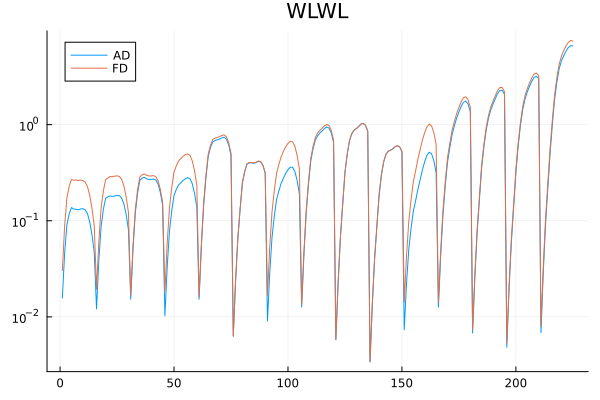

In [34]:
plot(abs.(diag(meta_wlwl.cov) .- diag(Cmod_wlwl_AD)) ./ diag(meta_wlwl.cov), label="AD", title="WLWL")
plot!(abs.(diag(meta_wlwl.cov) .- diag(Cmod_wlwl_FD)) ./ diag(meta_wlwl.cov), yscale=:log10, label="FD", title="WLWL")

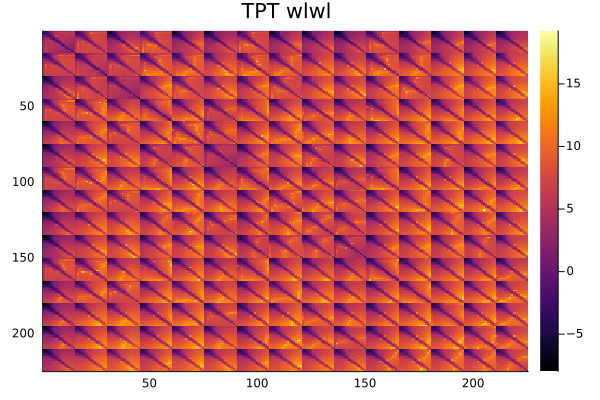

In [31]:
heatmap(log.(abs.((Cmod_wlwl_AD .- meta_wlwl.cov)./ meta_wlwl.cov)), title="TPT wlwl", yflip=true)

## GCGC

In [42]:
method = "bpz"
sacc_path = "./data/CosmoDC2/summary_statistics_fourier_tjpcov.sacc"
yaml_path = "./data/CosmoDC2/gcgc.yml"
nz_path = string("./data/CosmoDC2/image_nzs_", method, "_priors/")
dz_path = string("./data/CosmoDC2/image_dz_", method, "_priors/dz_prior.npz")
fake_data_path = string("./data/CosmoDC2/CosmoDC2_gcgc_theory_photo_", method, "_best.csv")

fake_data = CSV.read(fake_data_path, DataFrame)
fake_data = fake_data.theory[1:end-1]

sacc_file = sacc.Sacc().load_fits(sacc_path)
yaml_file = YAML.load_file(yaml_path)

nz_lens_0 = npzread(string(nz_path, "nz_lens_0.npz"))
nz_lens_1 = npzread(string(nz_path, "nz_lens_1.npz"))
nz_lens_2 = npzread(string(nz_path, "nz_lens_2.npz"))
nz_lens_3 = npzread(string(nz_path, "nz_lens_3.npz"))
nz_lens_4 = npzread(string(nz_path, "nz_lens_4.npz"))
zs_k0, nz_k0 = nz_lens_0["z"], nz_lens_0["dndz"]
zs_k1, nz_k1 = nz_lens_1["z"], nz_lens_1["dndz"]
zs_k2, nz_k2 = nz_lens_2["z"], nz_lens_2["dndz"]
zs_k3, nz_k3 = nz_lens_3["z"], nz_lens_3["dndz"]
zs_k4, nz_k4 = nz_lens_4["z"], nz_lens_4["dndz"]
mu_k0 = sum(zs_k0 .* nz_k0) / sum(nz_k0)
mu_k1 = sum(zs_k1 .* nz_k1) / sum(nz_k1)
mu_k2 = sum(zs_k2 .* nz_k2) / sum(nz_k2)
mu_k3 = sum(zs_k3 .* nz_k3) / sum(nz_k3)
mu_k4 = sum(zs_k4 .* nz_k4) / sum(nz_k4)

dz_prior = npzread(dz_path)
dz_mean, dz_cov = dz_prior["mean"], dz_prior["cov"]
dz_mean_gcgc = dz_mean[11:20]
dz_cov_gcgc = dz_cov[11:20, 11:20]
dz_chol_gcgc = cholesky(dz_cov_gcgc).U'

meta_gcgc, files_gcgc = make_data(sacc_file, yaml_file;
                        nz_lens_0=nz_lens_0,
                        nz_lens_1=nz_lens_1,
                        nz_lens_2=nz_lens_2,
                        nz_lens_3=nz_lens_3,
                        nz_lens_4=nz_lens_4)

meta_gcgc.types = [ 
    "galaxy_density",
    "galaxy_density",
    "galaxy_density",
    "galaxy_density",
    "galaxy_density"]

lens_0 lens_0 8
lens_1 lens_0 8
lens_1 lens_1 9
lens_2 lens_0 8
lens_2 lens_1 9
lens_2 lens_2 10
lens_3 lens_0 8
lens_3 lens_1 9
lens_3 lens_2 10
lens_3 lens_3 11
lens_4 lens_0 8
lens_4 lens_1 9
lens_4 lens_2 10
lens_4 lens_3 11
lens_4 lens_4 11
using custom nz for nz_lens_0
using custom nz for nz_lens_1
using custom nz for nz_lens_2
using custom nz for nz_lens_3
using custom nz for nz_lens_4


5-element Vector{String}:
 "galaxy_density"
 "galaxy_density"
 "galaxy_density"
 "galaxy_density"
 "galaxy_density"

In [43]:
plot(files_wlwl["nz_lens_0"][1], files_wlwl["nz_lens_0"][2], label="lens_0")
plot!(files_wlwl["nz_lens_1"][1], files_wlwl["nz_lens_1"][2], label="lens_1")
plot!(files_wlwl["nz_lens_2"][1], files_wlwl["nz_lens_2"][2], label="lens_2")
plot!(files_wlwl["nz_lens_3"][1], files_wlwl["nz_lens_3"][2], label="lens_3")
plot!(files_wlwl["nz_lens_4"][1], files_wlwl["nz_lens_4"][2], label="lens_4")

LoadError: KeyError: key "nz_lens_0" not found

In [44]:
function model_gcgc(alphas; meta=meta_gcgc, files=files_gcgc)
    SnWs = dz_mean_gcgc .+ dz_chol_gcgc * alphas
    dzs = [SnWs[1], SnWs[3], SnWs[5], SnWs[7], SnWs[9]]
    wzs = [SnWs[2], SnWs[4], SnWs[6], SnWs[8], SnWs[10]]
    lens_0_zs = @.((zs_k0-mu_k0)/wzs[1] + mu_k0 + dzs[1])
    lens_1_zs = @.((zs_k1-mu_k1)/wzs[2] + mu_k1 + dzs[2])
    lens_2_zs = @.((zs_k2-mu_k2)/wzs[3] + mu_k2 + dzs[3])
    lens_3_zs = @.((zs_k3-mu_k3)/wzs[4] + mu_k3 + dzs[4])
    lens_4_zs = @.((zs_k4-mu_k4)/wzs[5] + mu_k4 + dzs[5])

    nuisances = Dict(
        "source_0_b"    => 0.879118,
        "source_1_b"    => 1.05894,
        "source_2_b"    => 1.22145,
        "source_3_b"    => 1.35065,
        "source_4_b"    => 1.58909,
        "lens_0_zs"   => lens_0_zs,
        "lens_1_zs"   => lens_1_zs,
        "lens_2_zs"   => lens_2_zs,
        "lens_3_zs"   => lens_3_zs,
        "lens_4_zs"   => lens_4_zs,
        "source_0_m"  => -0.00733846,
        "source_1_m"  => -0.00434667,
        "source_2_m"  => 0.00434908,
        "source_3_m"  => -0.00278755,
        "source_4_m"  => 0.000101118)
        
    cosmo = Cosmology(
        Ωm=best_params[1],
        Ωb=best_params[2],
        h=best_params[3],
        σ8=best_params[4],
        ns=best_params[5],
        tk_mode=:EisHu,
        pk_mode=:Halofit)

    cosmo.settings.cosmo_type = eltype(valtype(alphas))
    return Theory(cosmo, meta, files; Nuisances=nuisances)
end;

In [45]:
Cmod_gcgc_FD = make_Cmod(dz_mean_gcgc, diagm(ones(10)), meta_gcgc.cov, model_gcgc; mode="FD")
Cmod_gcgc_AD = make_Cmod(dz_mean_gcgc, diagm(ones(10)), meta_gcgc.cov, model_gcgc; mode="AD")

Using finite differences to compute T
Using automatic differentiation to compute T


139×139 Symmetric{Float64, Matrix{Float64}}:
  1.41153e-9   -3.38109e-10   4.29683e-11  …   2.74438e-17   1.13918e-18
 -3.38109e-10   3.27093e-10  -4.00464e-11     -2.6446e-15    8.61996e-16
  4.29683e-11  -4.00464e-11   8.64291e-11     -4.83721e-15   1.56875e-15
 -6.53602e-12   2.20943e-11   2.32023e-11     -7.1358e-15    2.30984e-15
  2.13429e-13   2.05474e-11   3.8781e-11      -8.75086e-15   2.82973e-15
 -9.24968e-14   2.17172e-11   3.93547e-11  …  -9.00911e-15   2.91214e-15
 -2.99613e-14   1.99857e-11   3.63168e-11     -8.30494e-15   2.68389e-15
  7.50796e-14   1.63601e-11   2.9709e-11      -6.79335e-15   2.19514e-15
  2.08845e-10  -4.33853e-11   1.90879e-11     -5.64514e-14   1.7871e-14
 -5.03819e-11   5.52526e-11   3.08586e-12     -4.45266e-14   1.41056e-14
  6.34511e-12  -3.28588e-12   1.85846e-11  …  -3.36341e-14   1.06564e-14
 -9.7877e-13    4.40424e-12   5.38948e-12     -2.60131e-14   8.24325e-15
  1.27021e-14   2.59698e-12   4.95734e-12     -1.80863e-14   5.73535e-15
  ⋮    

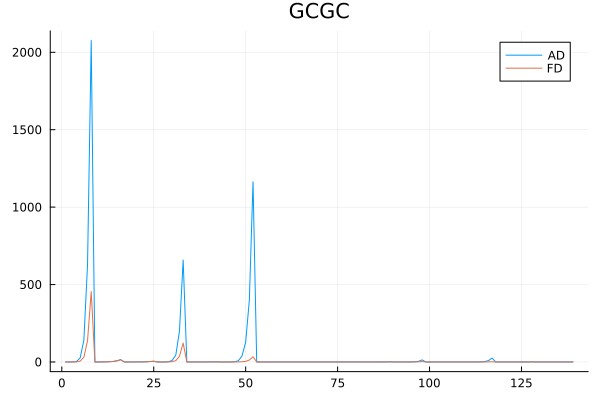

In [46]:
plot(abs.(diag(meta_gcgc.cov) .- diag(Cmod_gcgc_AD)) ./ diag(meta_gcgc.cov), label="AD", title="GCGC")
plot!(abs.(diag(meta_gcgc.cov) .- diag(Cmod_gcgc_FD)) ./ diag(meta_gcgc.cov), label="FD")

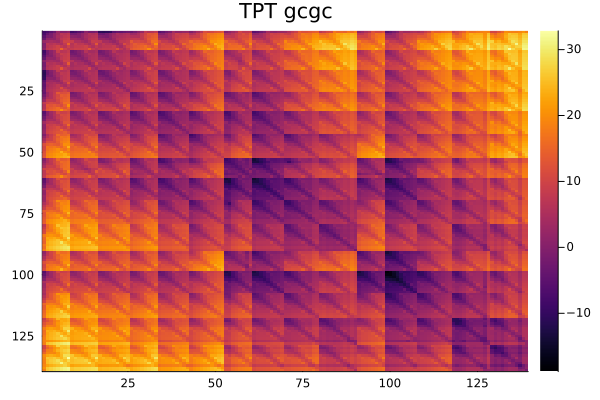

In [47]:
heatmap(log.(abs.((Cmod_gcgc_AD .- meta_gcgc.cov)./ meta_gcgc.cov)), title="TPT gcgc", yflip=true)

## 3x2

In [21]:
sacc_path = "../../PhD/LimberJack.jl/data/FD/cls_FD_covG.fits"
yaml_path_3x2 = "data/DESY1/gcgc_gcwl_wlwl.yml"
sacc_3x2 = sacc.Sacc().load_fits(sacc_path)
yaml_3x2 = YAML.load_file(yaml_path_3x2)
#nz_DESwl__0 = npzread(string(nz_path, "nz_DESwl__0.npz"))
#nz_DESwl__1 = npzread(string(nz_path, "nz_DESwl__1.npz"))
#nz_DESwl__2 = npzread(string(nz_path, "nz_DESwl__2.npz"))
#nz_DESwl__3 = npzread(string(nz_path, "nz_DESwl__3.npz"))
#nz_DESgc__0 = npzread(string(nz_path, "nz_DESgc__0.npz"))
#nz_DESgc__1 = npzread(string(nz_path, "nz_DESgc__1.npz"))
#nz_DESgc__2 = npzread(string(nz_path, "nz_DESgc__2.npz"))
#nz_DESgc__3 = npzread(string(nz_path, "nz_DESgc__3.npz"))
#nz_DESgc__4 = npzread(string(nz_path, "nz_DESgc__4.npz"))
meta_3x2, files_3x2 = make_data(sacc_3x2, yaml_3x2,
                                nz_DESwl__0=nz_DESwl__0,
                                nz_DESwl__1=nz_DESwl__1,
                                nz_DESwl__2=nz_DESwl__2,
                                nz_DESwl__3=nz_DESwl__3,
                                nz_DESgc__0=nz_DESgc__0,
                                nz_DESgc__1=nz_DESgc__1,
                                nz_DESgc__2=nz_DESgc__2,
                                nz_DESgc__3=nz_DESgc__3,
                                nz_DESgc__4=nz_DESgc__4);

DESgc__0 DESgc__0 5
DESgc__1 DESgc__1 8
DESgc__2 DESgc__2 10
DESgc__3 DESgc__3 11
DESgc__4 DESgc__4 13
DESgc__0 DESwl__0 5
DESgc__0 DESwl__1 5
DESgc__0 DESwl__2 5
DESgc__0 DESwl__3 5
DESgc__1 DESwl__0 8
DESgc__1 DESwl__1 8
DESgc__1 DESwl__2 8
DESgc__1 DESwl__3 8
DESgc__2 DESwl__0 10
DESgc__2 DESwl__1 10
DESgc__2 DESwl__2 10
DESgc__2 DESwl__3 10
DESgc__3 DESwl__0 11
DESgc__3 DESwl__1 11
DESgc__3 DESwl__2 11
DESgc__3 DESwl__3 11
DESgc__4 DESwl__0 13
DESgc__4 DESwl__1 13
DESgc__4 DESwl__2 13
DESgc__4 DESwl__3 13
DESwl__0 DESwl__0 24
DESwl__0 DESwl__1 24
DESwl__0 DESwl__2 24
DESwl__0 DESwl__3 24
DESwl__1 DESwl__1 24
DESwl__1 DESwl__2 24
DESwl__1 DESwl__3 24
DESwl__2 DESwl__2 24
DESwl__2 DESwl__3 24
DESwl__3 DESwl__3 24
using custom nz for nz_DESgc__0
using custom nz for nz_DESgc__1
using custom nz for nz_DESgc__2
using custom nz for nz_DESgc__3
using custom nz for nz_DESgc__4
using custom nz for nz_DESwl__0
using custom nz for nz_DESwl__1
using custom nz for nz_DESwl__2
using custom nz for

In [22]:
function model_3x2(x; meta=meta_3x2, files=files_3x2)
    cosmo = Cosmology(Ωm=0.3, Ωb=0.05, h=0.67, σ8=0.81, ns=0.96,
    tk_mode=:EisHu, pk_mode=:Halofit)
    nuisances = Dict(
        "DESgc__0_b" => 1.484,
        "DESgc__1_b" => 1.805,
        "DESgc__2_b" => 1.776,
        "DESgc__3_b" => 2.168,
        "DESgc__4_b" => 2.23,
        "DESwl__0_dz" => x[1],
        "DESwl__1_dz" => x[2],
        "DESwl__2_dz" => x[3],
        "DESwl__3_dz" => x[4],
        "DESgc__0_dz" => x[5],
        "DESgc__1_dz" => x[6],
        "DESgc__2_dz" => x[7],
        "DESgc__3_dz" => x[8],
        "DESgc__4_dz" => x[9],
        "DESwl__0_m" => 0.018,
        "DESwl__1_m" => 0.014,
        "DESwl__2_m" => 0.01,
        "DESwl__3_m" => 0.004,
        "A_IA" => 0.294,
        "alpha_IA" => 0.378) 
    cosmo.settings.cosmo_type = eltype(valtype(x))
    return Theory(cosmo, meta, files; Nuisances=nuisances)
end;

In [23]:
Cmod_3x2_FD = make_Cmod(dz_cov_3x2, meta_3x2.cov, model_3x2; mode="FD");
Cmod_3x2_AD = make_Cmod(dz_cov_3x2, meta_3x2.cov, model_3x2; mode="AD");

Using finite differences to compute T
Using automatic differentiation to compute T


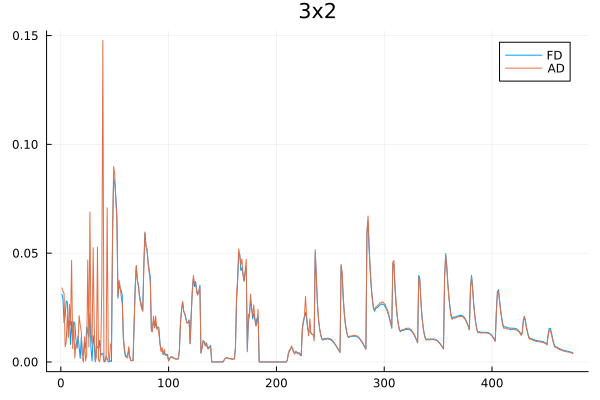

In [24]:
plot(abs.(diag(meta_3x2.cov) .- diag(Cmod_3x2_FD)) ./ diag(meta_3x2.cov), label="FD", title="3x2")
plot!(abs.(diag(meta_3x2.cov) .- diag(Cmod_3x2_AD)) ./ diag(meta_3x2.cov), label="AD")

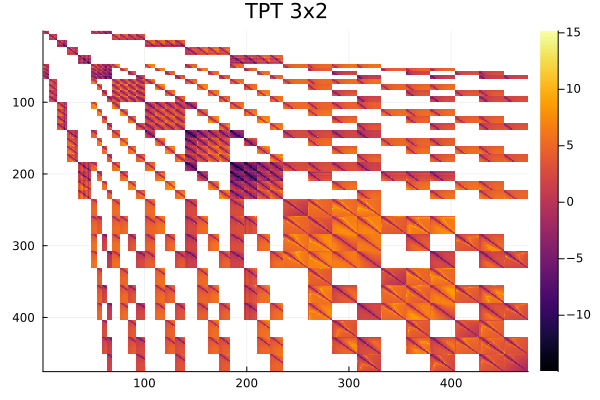

In [25]:
heatmap(log.(abs.((Cmod_3x2_AD .- meta_3x2.cov)./ meta_3x2.cov)), title="TPT 3x2", yflip=true)

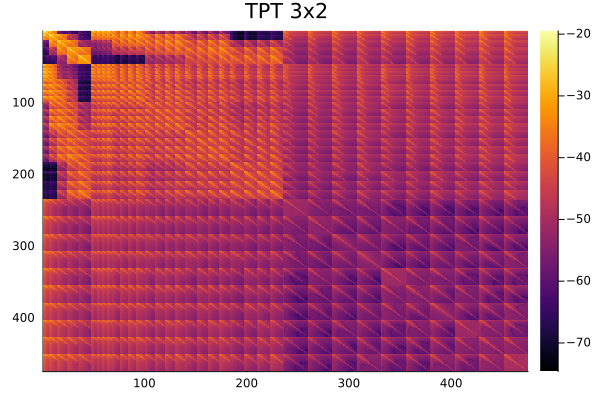

In [30]:
heatmap(log.(abs.((meta_3x2.cov))), title="TPT 3x2", yflip=true)

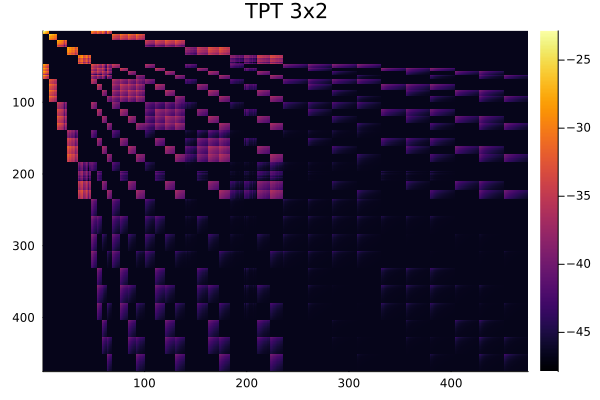

In [39]:
heatmap(log.(abs.((Cmod_3x2_AD .- meta_3x2.cov).+0.000000000000000000005)), title="TPT 3x2", yflip=true)

In [26]:
npzwrite("covs/dz_3x2_covs.npz",
        Dict(
        "3x2_AD" => Cmod_3x2_AD,
        "3x2_FD" => Cmod_3x2_FD))

## Save

In [27]:
using NPZ
npzwrite("covs/dz_covs.npz",
        Dict(
        "wlwl_AD" => Cmod_wlwl_AD,
        "wlwl_FD" => Cmod_wlwl_FD,
        "gcgc_AD" => Cmod_gcgc_AD,
        "gcgc_FD" => Cmod_gcgc_FD,
        "3x2_AD" => Cmod_3x2_AD,
        "3x2_FD" => Cmod_3x2_FD))